In [33]:
import time
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from ast import literal_eval
import random
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 9999)
pd.set_option('display.max_rows', 50)
%matplotlib inline

In [5]:
df = pd.read_csv('./data/paccr_drmm_.csv', converters={"negative_sim_matrix": literal_eval,
                                                        "positive_sim_matrix": literal_eval,
                                                        "idf_softmax": literal_eval})
df = df[['query_preprocessed', 'negative_sim_matrix', 'positive_sim_matrix', 'idf_softmax']]

In [6]:
train_q = set(random.sample(list(df['query_preprocessed'].unique()), int(len(df['query_preprocessed'].unique()) * 0.9)))
dev_q = set(df['query_preprocessed'].unique()) - train_q

In [7]:
train = pd.concat([df.groupby('query_preprocessed').get_group(name) for name in train_q])
dev = pd.concat([df.groupby('query_preprocessed').get_group(name) for name in dev_q])

In [8]:
# df shuffle 
train = train.sample(frac=1).reset_index(drop=True)
dev = dev.sample(frac=1).reset_index(drop=True)

In [9]:
metadata = {'negative_sim_matrix': train['negative_sim_matrix'].values, 
            'positive_sim_matrix': train['positive_sim_matrix'].values,
            'idf_softmax': train['idf_softmax'].values}

In [10]:
metadata_dev = {'negative_sim_matrix': dev['negative_sim_matrix'].values, 
                'positive_sim_matrix': dev['positive_sim_matrix'].values,
                'idf_softmax': dev['idf_softmax'].values}  

In [11]:
num_samples = len(train)
num_samples_dev = len(dev)
#PACCR Hyperparameter
firstk = 8
lq = 6
lg = 5
nf = 32
ns = 2

In [12]:
dev_set = {}
for key, val in metadata_dev.items():
    dev_set[key] = tf.stack([val[j] for j in range(num_samples_dev)], axis=0)

In [13]:
batchs = 128
def meta_dict_gen():
    for i in range(num_samples//batchs):
        ls = {}
        for key, val in metadata.items():
            ls[key] = tf.stack([val[j] for j in range(batchs*i, batchs*(i+1))], axis=0)
        yield ls

In [14]:
dataset = tf.data.Dataset.from_generator(
    meta_dict_gen,
    output_types={k: tf.float32 for k in metadata},
    output_shapes={'negative_sim_matrix': (batchs, lq, firstk), 'positive_sim_matrix': (batchs, lq, firstk), 'idf_softmax': (batchs, lq)}
)

In [15]:
iterator = iter(dataset)
next_element = iterator.get_next()

In [16]:
del df, train, dev

In [17]:
class Conv_stack(tf.keras.layers.Layer):
    def __init__(self, lg, nf):
        super(Conv_stack, self).__init__(name='ConV_stack')
        self.lg = lg
        self.nf = nf
        self.conv_dict = {}
        for i in range(2, self.lg+1):
            self.conv_dict[i] = tf.keras.layers.Conv2D(self.nf, i, strides=(1, 1), padding='same')

    def call(self, inputs):
        inputs = tf.expand_dims(inputs, axis=-1)
        x_1 = inputs
        x = {}
        for i in range(2, self.lg+1):
            x[i] = self.conv_dict[i](inputs)
        return tf.keras.layers.concatenate([x_1] + [x[k] for k in x]) 

In [18]:
class Dim_wise_max_pooling(tf.keras.layers.Layer):
    def __init__(self, lg, nf):
        super(Dim_wise_max_pooling, self).__init__(name='dim_wise_max_pooling')
        self.lg = lg
        self.nf = nf
        
    def call(self, inputs):
        channel_range = [self.nf*i+1 for i in range(self.lg)]
        x_1 = inputs[:, :, :, 0]
        x = {}
        for i in range(2, self.lg+1):
            x[i] = tf.reduce_max(inputs[:, :, :, channel_range[i-2]:channel_range[i-1]], axis=-1)
            
        return tf.keras.layers.concatenate([x_1] + [x[k] for k in x])

In [19]:
class Row_wise_max_pooling(tf.keras.layers.Layer):
    def __init__(self, ns, lg, firstk):
        super(Row_wise_max_pooling, self).__init__(name='row_wise_max_pooling')
        self.ns = ns
        self.lg = lg
        self.firstk = firstk
        
    def call(self, inputs):
        x = {}
        for i in range(1, self.lg+1):
            x[i] = tf.math.top_k(inputs[:, :, self.firstk*(i-1):self.firstk*i], k=self.ns)[0]
            
        return tf.keras.layers.concatenate([x[k] for k in x])

In [20]:
class Idf_concat(tf.keras.layers.Layer):
    def __init__(self):
        super(Idf_concat, self).__init__(name='idf_concat')
        
    def call(self, inputs, idf):
        expand_idf = tf.expand_dims(idf, axis=-1)
        return tf.keras.layers.concatenate([inputs, expand_idf])

In [21]:
class PACCR(tf.keras.Model):
    def __init__(self, firstk, lq, lg, nf, ns):
        super(PACCR, self).__init__(name='')
        self.firstk = firstk
        self.lq = lq
        self.lg = lg
        self.nf = nf
        self.ns = ns
        
        self.conv_stack = Conv_stack(lg=self.lg, nf=self.nf)
        self.dim_wise_max_pooling = Dim_wise_max_pooling(lg=self.lg, nf=self.nf)
        self.row_wise_max_pooling = Row_wise_max_pooling(lg=self.lg, ns=self.ns, firstk=self.firstk)
        self.idf_concat = Idf_concat()

    def call(self, inputs, idf):
        x = self.conv_stack(inputs)
        x = self.dim_wise_max_pooling(x)
        x = self.row_wise_max_pooling(x)
        x = self.idf_concat(x, idf)
        return x

In [22]:
class DRMM(tf.keras.Model):
    def __init__(self):
        super(DRMM, self).__init__(name='DRMM')
        initializer = tf.keras.initializers.he_normal()
        self.dense1 = tf.keras.layers.Dense(5, activation='relu', kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(1, activation='relu', kernel_initializer=initializer)
        self.dense3 = tf.keras.layers.Dense(1, activation='relu', kernel_initializer=initializer)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = tf.squeeze(x)
        x = self.dense3(x)
        
        return x

In [23]:
class PACCR_DRMM(tf.keras.Model):
    def __init__(self, firstk, lq, lg, nf, ns):
        super(PACCR_DRMM, self).__init__(name='')
        self.firstk = firstk
        self.lq = lq
        self.lg = lg
        self.nf = nf
        self.ns = ns
        
        self.paccr = PACCR(firstk=self.firstk, lq=self.lq, lg=self.lg, nf=self.nf, ns=self.ns)
        self.drmm = DRMM()
        
    def call(self, inputs, idf):
        x = self.paccr(inputs, idf)
        x = self.drmm(x)
        return x

In [24]:
class Pairwise_PACCR_DRMM(tf.keras.Model):
    def __init__(self, firstk, lq, lg, nf, ns):
        super(Pairwise_PACCR_DRMM, self).__init__(name='Pairwise_PACCR_DRMM')
        self.Paccr_Drmm = PACCR_DRMM(firstk, lq, lg, nf, ns)
        
    def call(self, inputs):
        positive_sim = inputs['positive_sim_matrix']
        negative_sim = inputs['negative_sim_matrix']
        idf_softmax = inputs['idf_softmax']
        
        positive = self.Paccr_Drmm(positive_sim, idf_softmax)
        negative = self.Paccr_Drmm(negative_sim, idf_softmax)
        
        return tf.concat([positive, negative], axis=0) 
    
    def predict(self, inputs):
        sim_matrix = inputs['sim_matrix']
        idf_softmax = inputs['idf_softmax']
        rel = self.Paccr_Drmm(sim_matrix, idf_softmax)
        return rel

In [25]:
def Pairwise_ranking_loss(y_true, y_pred):
    '''
    ignore y_true
    '''
    positive_score = tf.keras.layers.Lambda(lambda x: x[:len(x)//2], output_shape= (1,))(y_pred)
    negative_score = tf.keras.layers.Lambda(lambda x: x[len(x)//2:], output_shape= (1,))(y_pred)

    return tf.keras.backend.mean(tf.math.maximum(0, 1 - positive_score + negative_score))

In [26]:
test = pd.read_csv('./data/paccr_drmm_test.csv', converters={"sim_matrix": literal_eval,
                                                             "idf_softmax": literal_eval})

In [27]:
def ndcg(rel_pred, p=None, form="linear"):
    if p==None:
        p = len(rel_pred)
    if p > len(rel_pred):
        rel_pred = np.append(rel_pred, [0]*(p - len(rel_pred)))
    
    rel_true = np.sort(rel_pred)[::-1]
    discount = 1 / (np.log2(np.arange(p) + 2))

    if form == "linear":
        idcg = np.sum(rel_true[:p] * discount)
        dcg = np.sum(rel_pred[:p] * discount)
    elif form == "exponential" or form == "exp":
        idcg = np.sum([2**x - 1 for x in rel_true[:p]] * discount)
        dcg = np.sum([2**x - 1 for x in rel_pred[:p]] * discount)
    else:
        raise ValueError("Only supported for two formula, 'linear' or 'exp'")
    
    return dcg / idcg

In [74]:
batchs = 32
def meta_dict_gen():
    for i in range(num_samples//batchs):
        ls = {}
        for key, val in metadata.items():
            ls[key] = tf.stack([val[j] for j in range(batchs*i, batchs*(i+1))], axis=0)
        yield ls
        
dataset = tf.data.Dataset.from_generator(
    meta_dict_gen,
    output_types={k: tf.float32 for k in metadata},
    output_shapes={'negative_sim_matrix': (batchs, lq, firstk), 'positive_sim_matrix': (batchs, lq, firstk), 'idf_softmax': (batchs, lq)}
)

In [83]:
tf.keras.backend.clear_session()
model = Pairwise_PACCR_DRMM(firstk, lq, lg, nf, ns)
n = 20
learning_rate = 1
print_step = 10
optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

Pairwise_ranking_loss(y_true=None, y_pred=model(next_element))

<tf.Tensor: shape=(), dtype=float32, numpy=0.97907966>

In [84]:
loss_sum = 0
ndcg_sum = 0
step_history = []
loss_history = []
loss_history_dev = []
ndcg_history = []

start = time.time()
for step, batch_train in enumerate(dataset):
    
    with tf.GradientTape() as tape:
        logits = model(batch_train)
        loss_value = Pairwise_ranking_loss(y_true=None, y_pred=logits)
        loss_sum += loss_value 
        
        if step == 0:
            loss_history_dev.append(Pairwise_ranking_loss(y_true=None, y_pred=model(dev_set)))
            
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    if step % print_step == 0:
        current_loss_average = float(loss_sum)/print_step
        if step ==0:
            current_loss_average = loss_sum

        logits_dev = model(dev_set)
        current_loss_average_dev = Pairwise_ranking_loss(y_true=None, y_pred=logits_dev)
        
            
        for q in dev_q:
            ndcg_test = test[test['query_preprocessed'] == q]
            metadata_ndcg = {'sim_matrix': tf.stack([ndcg_test['sim_matrix'].values[j] for j in range(len(ndcg_test))], axis=0), 
                             'idf_softmax': tf.stack([ndcg_test['idf_softmax'].values[j] for j in range(len(ndcg_test))], axis=0)}  
            ndcg_test['rel'] = model.predict(metadata_ndcg).numpy()
            rel_pred = list(ndcg_test.sort_values(by=['rel'], axis=0, ascending=False)['median_relevance']-1)
            ndcg_sum += ndcg(rel_pred, p=n, form="exp")
        current_ndcg_average = ndcg_sum/len(dev_q)
        
        step_history.append(step)
        loss_history.append(current_loss_average)
        loss_history_dev.append(current_loss_average_dev)
        ndcg_history.append(current_ndcg_average)
        
        print("Training loss at step %d: %.5f, dev_loss : %.5f, nDCG@20 : %.5f"% (step, 
                                                                  current_loss_average, 
                                                                  current_loss_average_dev,
                                                                  current_ndcg_average))
        print("Seen so far: %s train samples, learning rate: %.4f" % ((step + 1) * batchs, learning_rate))
        ndcg_sum = 0
        loss_sum = 0
        start = time.time()
        
#     if current_ndcg_average > 0.862 or step==120:
#         break
    
    if step % 500 == 0:
        learning_rate *= .1
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)

Training loss at step 0: 1.00758, dev_loss : 0.94723, nDCG@20 : 0.83979
Seen so far: 32 train samples, learning rate: 1.0000
Training loss at step 10: 0.85048, dev_loss : 0.70869, nDCG@20 : 0.83810
Seen so far: 352 train samples, learning rate: 0.1000
Training loss at step 20: 0.84516, dev_loss : 0.72975, nDCG@20 : 0.84493
Seen so far: 672 train samples, learning rate: 0.1000
Training loss at step 30: 0.81668, dev_loss : 0.68039, nDCG@20 : 0.84904
Seen so far: 992 train samples, learning rate: 0.1000
Training loss at step 40: 0.70091, dev_loss : 0.67155, nDCG@20 : 0.84809
Seen so far: 1312 train samples, learning rate: 0.1000
Training loss at step 50: 0.80039, dev_loss : 0.66029, nDCG@20 : 0.85074
Seen so far: 1632 train samples, learning rate: 0.1000
Training loss at step 60: 0.78985, dev_loss : 0.67114, nDCG@20 : 0.85760
Seen so far: 1952 train samples, learning rate: 0.1000
Training loss at step 70: 0.80714, dev_loss : 0.66476, nDCG@20 : 0.85073
Seen so far: 2272 train samples, lear

KeyboardInterrupt: 

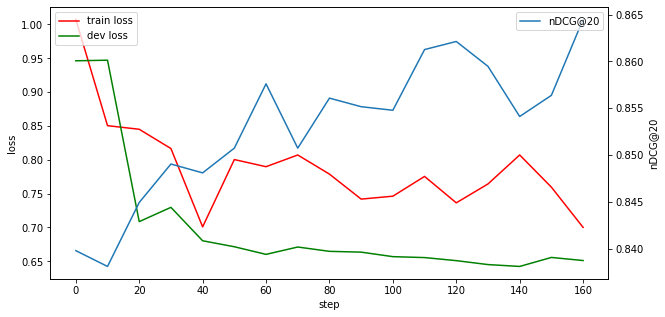

In [87]:
fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:red'
ax1.set_xlabel('step')
ax1.set_ylabel('loss')
ax1.plot(step_history, loss_history, color='r', label='train loss')
ax1.plot(step_history, loss_history_dev[:-1], color='g', label='dev loss')
# ax1.set_ylim(0.8, 1.1)
ax1.legend(loc=2)


ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('nDCG@20')  
ax2.plot(step_history, ndcg_history, color=color, label='nDCG@20')
ax2.legend(loc=1)
# ax2.set_ylim(0.87, 0.94)
plt.show()

In [135]:
ndcg_test = test[test['query_preprocessed'] == 'nike flip flop']

metadata_ndcg = {'sim_matrix': tf.stack([ndcg_test['sim_matrix'].values[j] for j in range(len(ndcg_test))], axis=0), 
                 'idf_softmax': tf.stack([ndcg_test['idf_softmax'].values[j] for j in range(len(ndcg_test))], axis=0)}  

ndcg_test.insert(5, 'rel', model.predict(metadata_ndcg).numpy(), True)

ndcg_test.sort_values(by=['rel'], axis=0, ascending=False)[['query', 'product_title', 'median_relevance', 'rel']].head(20)

,query,product_title,median_relevance,rel
4425,nike flip flops,Nike Aqua Motion Girls Flip Flops - Little Kids/Big Kids,4,7.834347
7602,nike flip flops,Women's Nike 'SolarSoft 11' Flip Flop,4,7.709078
6627,nike flip flops,Women's Nike 'Flex Motion' Flip Flop,4,7.705331
841,nike flip flops,"Women's Nike 'SolarSoft 11' Flip Flop, Size 8 M - Black",4,7.663935
2601,nike flip flops,"Women's Nike 'SolarSoft 11' Flip Flop, Size 6 M - Black",4,7.663935
6738,nike flip flops,Women's C9 by Champion Lindie Flip Flop Sandals - Assorted Colors,2,7.148888
8157,nike flip flops,OP Women's Eyelit EVA Flip Flop,2,7.069069
4361,nike flip flops,Nike Girls' Celso Girl Thong Sandals from Finish Line,4,7.035944
4095,nike flip flops,Girls Hester Flip Flop Sandals - Grey/Fuchsia,4,7.021328
3989,nike flip flops,Nike Women's Celso Girl Thong Sandals from Finish Line,4,6.910518
